Introduction:
-------------
This is a Python notebook serves as a scripted implimentation of a speach classifier workfow which will ultimitely be implimented, and executed, in the VisTrails environment.  A successfull implimentation of this notebook demonstrates that a scalible, extensible layer of functional components can be implimented that will accomplish the goal of the analysis task in a manner that is logical, readible, efficient, and can be emloyed to accomplish other analysis tasks utilizing the various sub-components. 


The Goal:
---------
This analysis task for this workflow is to classify phonetic sounds ("phones") using a classifier that has been trained over the formant trajectories af a large sample data set.  This sample data set consists of WAV/label_file pairings for a group of "n" speakers.  The main steps in this process are as follows:<br />

- step1:  convert label-file phone interval data into textgrid files.<br />
- step2:  compute the first 3 formants of the WAV files using "wrassp" library<br />
- step3:  using the textgrid interval data, pull the formant trajectories from the formant data calculated in step 2<br />
- step4:  conduct round-robin training and testing using the first 3 coeficients of the trajectory data as the training input.<br />
- step5:  build a confusion matrix from the results of the training/testing rounds, and analyze the effectiveness.<br />

In [1]:
#-----------------------------imports----------------------------------
%matplotlib inline
import tgt as tgt
import matplotlib.pyplot as plt
import os
from scipy import fftpack
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import subprocess
import pandas as pd
import numpy as np
from IPython.display import display

In [2]:
#------------------------------setup-----------------------------------
workspacePath = "/Users/alec/Documents/ntbk/notebk2/children"                      #location of sample data
speakers = ["sp1","sp2","sp3","sp4","sp5","sp6","sp7","sp8"]                       #speakers that will be analyzed
targetPhones = set(['u:', 'A', 'ai', 'o:', 'au', 'V', 'U', 'i:', 'w', 'n'])        #target phones to analyze

Step1:  Build Textgrids from label files
------

Here is where the label files will get converted into textgrid files.  this is done simply by walking through the tabbed values and storing them in their appropriate category --- and then the TGT package is used to built a python textgrid object that can be passed around, or saved to the file system.  This step is not completely neccesary, as the lab files already contain all the desired information.  However, because TextGrids are highly compatible and modifiable thanks to the TGT package, this step has its merits. 

In [3]:
#--------------------------------function to create textGrid from label file------------------------------
def labToTextgrid(labFile_fileObject, ID=""):
    labFileData = [str(line).splitlines()[0].split("\t") for line in labFile_fileObject.readlines()]
    newTextGrid = tgt.TextGrid(ID)
    phnTier = tgt.IntervalTier(name="PHN")
    startTimeIndex = 0
    for stamp in range(3,len(labFileData)):          #---start---                ---end---                 ---phone---
        phnTier.add_annotation(tgt.Annotation(float(startTimeIndex), float(labFileData[stamp][1]), str(labFileData[stamp][3])))
        startTimeIndex = labFileData[stamp][1]
    newTextGrid.add_tier(phnTier)
    return(newTextGrid)


#-------------------------------execute creation of textGrids from label files-----------------------------------
textgrid_dFrame = pd.DataFrame([], columns=['ID', 'Speaker', 'TextGrid'])
for speaker in speakers:
    labFileDirectory = workspacePath+"/"+speaker+"/labels"
    labelFileNames = [n[0]+"."+n[1]+"."+n[2] for n in [f.split(".") for f in os.listdir(labFileDirectory)] if n[-1] == 'lab']
    for labFile in labelFileNames:
        ID = labFile.split('.lab')[0]
        textGrid = labToTextgrid(open(labFileDirectory+"/"+labFile, "r"), ID)       #save textgrid
        textgrid_dFrame = textgrid_dFrame.append(pd.DataFrame({'ID':[ID], 'Speaker':[speaker], 'TextGrid':[textGrid]}))
               
display(textgrid_dFrame[:3])

                                 

ID Speaker                                           TextGrid
0  sp1.1249     sp1  ((Annotation(0.0, 1.9075, "H#"), Annotation(1....
0  sp1.1457     sp1  ((Annotation(0.0, 1.68002, "H#"), Annotation(1...
0  sp1.2121     sp1  ((Annotation(0.0, 2.3801, "H#"), Annotation(2....

------------------------------------------
Step2: Track formants for each Wav file
------

This stage compute formants over every Wav files in the data set.  "Formant Maps" containing the first 3 formants are currently stored in a Formant class shown below.  It also includes a method usefull for pulling out formant slices between specified intervals.
<br/><br/>
The getFormantsWRASSP() function utilizes the WRASSP library (through a subprocess call to R)  to compute the first three formants and return them as a Formant object.

In [4]:

class Formant(object):
    #formantData: -> [-------------------------------------------------------------------------------------------------]
    #                 [-----timestamp1-----]  , [--------f1--------] , [--------f2--------] , [--------f3--------]]
    #                   val1, val2, val3...
    #
    def __init__(self, formantData):
        self.timestamp = formantData[0]
        self.f1 = formantData[1]
        self.f2 = formantData[2]
        self.f3 = formantData[3]

    def pullIntervalsFromTimeline(self, startTime, endTime):
        f1_pulled = []
        f2_pulled = []
        f3_pulled = []
        for i in range(0, len(self.timestamp)):
            if (self.timestamp[i] > startTime and self.timestamp[i] < endTime):
                f1_pulled.append(self.f1[i])
                f2_pulled.append(self.f2[i])
                f3_pulled.append(self.f3[i])
        return [f1_pulled, f2_pulled, f3_pulled]

    def get_timestamp(self):
        return self.timestamp
    def get_f1(self):
        return self.f1
    def get_f2(self):
        return self.f2
    def get_f3(self):
        return self.f3



#---------------------------------------map formants---------------------------------------
def getFormantsWRASSP(wavPath, startTime, endTime):
    formantData = []
    scriptDir = '/Users/alec/Documents/ntbk/notebk2/R_Scripts/formTest.R'
    output = subprocess.check_output(['Rscript',
                                      scriptDir,
                                      wavPath,
                                      str(startTime),
                                      str(endTime)],
                                      shell=False).split(' ', 2)
    numberOfFormantSlices = int(output[0])
    formantSliceDuration = 1/float(output[1])
    dataList = map(int, output[2].split())
    numberOfFormants = 3
    formantData.append([formantSliceDuration*i + formantSliceDuration/2 for i in range(0, numberOfFormantSlices)])  #timestamps
    formantData.extend([dataList[i*numberOfFormantSlices : (i+1)*numberOfFormantSlices] for i in range(0, numberOfFormants+2)])
                                    #-----start------       #----------end-----------
    return Formant(formantData)



#------------------------Execute: Compute Formants for each Wav----------------------------
formants_dFrame = pd.DataFrame([], columns=['ID', 'Speaker', 'TextGrid', 'Formant_Map'])
for index, row in textgrid_dFrame.iterrows():
    textGrid = row['TextGrid']
    wavPath = workspacePath+"/"+row['ID'].split('.')[0]+"/"+"wavs"+"/"+row['ID']+".wav"
    formantMap = getFormantsWRASSP(wavPath, textGrid.start_time, textGrid.end_time)
    formants_dFrame = formants_dFrame.append(pd.DataFrame({'ID':row['ID'], 'Speaker':row['Speaker'], 'TextGrid':row['TextGrid'], 'Formant_Map':[formantMap]}))
display(formants_dFrame[:3])




Formant_Map        ID Speaker  \
0   <__main__.Formant object at 0x110c01e90>  sp1.1249     sp1   
0  <__main__.Formant object at 0x1c14b5d250>  sp1.1457     sp1   
0  <__main__.Formant object at 0x1c14b5d1d0>  sp1.2121     sp1   

                                            TextGrid  
0  ((Annotation(0.0, 1.9075, "H#"), Annotation(1....  
0  ((Annotation(0.0, 1.68002, "H#"), Annotation(1...  
0  ((Annotation(0.0, 2.3801, "H#"), Annotation(2....

-----------------------------------------------
Step3:  Get formant trajectories of phones
-----
<br/>
Using the intervals specified in the TextGrid objects, and formant values calculated in the previous step, pull out the formant trajectories for each target phone present in the data.



In [5]:
#--------------------------getting phone formant trajectories-------------------------------
def getPhoneIntervals_fromTextgrid(textgrid, target, phoneTier):
    vowelTier = textgrid.get_tier_by_name('PHN')
    vowelAnnotations = vowelTier.get_annotations_with_text(pattern=target, n=0, regex=False)
    intervals = [[float(annotation._start_time), float(annotation._end_time)] for annotation in vowelAnnotations]
    return intervals


def getPhoneTrajectory_fromTextgrid(textgrid, formantMap, target, phoneTier):
    return [formantMap.pullIntervalsFromTimeline(interval[0], interval[1])
            for interval in getPhoneIntervals_fromTextgrid(textgrid, target, phoneTier)]



#-------------------------------Execute: Compute trajectories for each phone-------------------------------------
trajectories_dFrame = pd.DataFrame([], columns=['ID', 'Speaker', 'Phone', 'f1_traj', 'f2_traj', 'f3_traj'])
for index, row in formants_dFrame.iterrows():
    textGrid = row['TextGrid']
    targetsPresent = list(set([str(interval.text) for interval in textGrid.get_tier_by_name('PHN')]) & targetPhones)
    wavPath = workspacePath+"/"+row['ID'].split('.')[0]+"/"+"wavs"+"/"+row['ID']+".wav"
    formantMap = row['Formant_Map']
    for target in targetsPresent:
        trajectories = map(list, zip(*getPhoneTrajectory_fromTextgrid(textGrid, formantMap, target, 'PHN')))
        ID_list = [row['ID'] for trajectory in trajectories[0]]             
        phone_list = [target for trajectory in trajectories[0]]        
        speaker_list = [row['Speaker'] for trajectory in trajectories[0]]              
        trajectories_dFrame = trajectories_dFrame.append(pd.DataFrame({'ID':ID_list, 'Speaker':speaker_list, 'Phone':phone_list, 'f1_traj':trajectories[0], 'f2_traj':trajectories[1], 'f3_traj':trajectories[2]}))      
display(trajectories_dFrame[:3])


ID Phone Speaker                                            f1_traj  \
0  sp1.1249    u:     sp1  [271, 327, 336, 346, 351, 348, 347, 344, 346, ...   
0  sp1.1249    ai     sp1  [350, 389, 393, 397, 412, 414, 401, 403, 412, ...   
0  sp1.1249     n     sp1  [361, 354, 348, 345, 345, 345, 346, 348, 350, ...   

                                             f2_traj  \
0  [0, 0, 2323, 2212, 2166, 2202, 1198, 1145, 110...   
0  [1104, 1081, 1049, 1057, 1732, 1116, 1146, 126...   
0  [1299, 1444, 1354, 1225, 1106, 1036, 1035, 102...   

                                             f3_traj  
0  [2513, 2499, 2522, 2587, 2593, 2545, 2446, 239...  
0  [2139, 2240, 1974, 1847, 2463, 1723, 1729, 165...  
0  [2451, 2454, 2454, 2449, 2437, 2429, 2433, 243...

Step4: Discard zero values, and normalize the trajectory data.
-----
This step goes through all of the calculated trajectories and "normalizes" them.  This makes all of the trajectory data fit within a fixed, uniform size, while maintaining the geometry of the trajectory.  Any zero values that have been mis-tracked are also removed.
<break/>
The first 3 DCT coeficients are then calculated using the scipy fft library --- these values will be used to train the classifier in the next step.  These DCT coeficients allow for the characteristics of the trajectory data to be represented in a more succienct form.

In [6]:
#------------------------------------function to normalize trajectories------------------------------------------------
def normalizeFormantTimeSeries_Interpolate(formantValues, factor):
    result = []
    offsetRatio = float(len(formantValues)-1)/float(factor-1)
    for i in range(0,factor):
        offsetIndex = i*offsetRatio
        valueRange = formantValues[min(len(formantValues)-1,int(offsetIndex)+1)] - formantValues[int(offsetIndex)]
        offsetAmount = offsetIndex - int(offsetIndex)
        result.append(formantValues[int(offsetIndex)] + (valueRange*offsetAmount))
        #value     =                  ---index---    +    ---offset amount---
    return result



#---normalize data and compute DCT coefficients--
normalizedTraj_dFrame = trajectories_dFrame.filter(['ID', 'Speaker', 'Phone'], axis=1)
normalizedTraj_dFrame['f1_traj_normalized'] = trajectories_dFrame['f1_traj'].apply(lambda x: normalizeFormantTimeSeries_Interpolate([y for y in x if y>0], 40))
normalizedTraj_dFrame['f2_traj_normalized'] = trajectories_dFrame['f2_traj'].apply(lambda x: normalizeFormantTimeSeries_Interpolate([y for y in x if y>0], 40))
normalizedTraj_dFrame['f3_traj_normalized'] = trajectories_dFrame['f3_traj'].apply(lambda x: normalizeFormantTimeSeries_Interpolate([y for y in x if y>0], 40))
normalizedTraj_dFrame['dct'] = normalizedTraj_dFrame['f1_traj_normalized'].apply(lambda x: fftpack.dct(x)[0:3].tolist()) + \
                normalizedTraj_dFrame['f2_traj_normalized'].apply(lambda x: fftpack.dct(x)[0:3].tolist()) + \
                normalizedTraj_dFrame['f3_traj_normalized'].apply(lambda x: fftpack.dct(x)[0:3].tolist())

display(normalizedTraj_dFrame[:3])


ID Speaker Phone                                 f1_traj_normalized  \
0  sp1.1249     sp1    u:  [271.0, 335.538461538, 350.487179487, 347.1538...   
0  sp1.1249     sp1    ai  [350.0, 392.384615385, 407.384615385, 407.0, 4...   
0  sp1.1249     sp1     n  [361.0, 355.615384615, 350.769230769, 347.0769...   

                                  f2_traj_normalized  \
0  [2323.0, 2202.56410256, 2180.76923077, 1584.15...   
0  [1104.0, 1050.64102564, 1662.76923077, 1141.38...   
0  [1299.0, 1410.53846154, 1395.53846154, 1314.30...   

                                  f3_traj_normalized  \
0  [2513.0, 2520.82051282, 2592.38461538, 2461.23...   
0  [2139.0, 1987.64102564, 2399.82051282, 1728.07...   
0  [2451.0, 2453.30769231, 2454.0, 2452.46153846,...   

                                                 dct  
0  [37391.7435897, 438.693315572, -4400.44521847,...  
0  [32995.5384615, -1846.57194509, 978.839549016,...  
0  [27348.0, 624.944037863, -558.396786124, 95435...

-------------------------------
Step5:  Train Classifier
-----
In this step, "round robin" training and testing is performed on data set, where each speaker has a turn being the test-set while the rest of the speaker data is used as the training set. A classifier constructor is passed as a parameter to the roundRobin function --- with this, a classifier of any type is created for each speaker training/test group and stored in "classifiers". These classifiers are then trained for their respective roles in the round-robin testing. This is illustrated below:


    classifiers: [classifier1, classifier2, classifier2, ...]
    allClassificationData = [speaker]
                                |
                                [inputs, outputs]
                                   |        |
                                   |    expected phone
                                   |
                                  [dct(f1_traj) + dct(f2_traj), dct(f3_traj)]
                                  
<br/>

    -------------------------------------------------------
    round1:
    classifier:  classifier1
    train:       [allClassificationData[1], allClassificationData[2] ,..., allClassificationData[numOfSpeakers]]
    test:        allClassificationData[0]
    -------------------------------------------------------
    round2:
    classifier:  classifier2
    train:       [allClassificationData[0], allClassificationData[2] ,..., allClassificationData[numOfSpeakers]]
    test:        allClassificationData[1]
    -------------------------------------------------------
    ...



In [7]:
#--------------------------------function to train classifier (round robbin)---------------------------------
def roundRobbin(dataFrame, factorID, dataIn, dataOut, classifierConstructor):
    factorValues = dataFrame[factorID].unique().tolist()
    classifiers = [classifierConstructor for factor in factorValues]
    results = []
    for i in range(0,len(factorValues)):
        trainingData = [list(dataFrame[dataFrame[factorID] != factorValues[i]][dataIn]), list(dataFrame[dataFrame[factorID] != factorValues[i]][dataOut])]
        testData = [list(dataFrame[dataFrame[factorID] == factorValues[i]][dataIn]), list(dataFrame[dataFrame[factorID] == factorValues[i]][dataOut])]
        classifiers[i].fit(trainingData[0], trainingData[1])
        predictions = classifiers[i].predict(testData[0])
        results.append([predictions, testData[1]])
    return results


#-------------------------------------------train over data----------------------------------------------
predictions_bySpeaker = roundRobbin(normalizedTraj_dFrame, 'Speaker', 'dct', 'Phone', GaussianNB())
allInputs = [item for sublist in [x[0] for x in predictions_bySpeaker] for item in sublist]
allOutputs = [item for sublist in [x[1] for x in predictions_bySpeaker] for item in sublist]



Step6:  Analyze the classification results.  
------
Using a confusion matrix, the effectiveness of the classifier can be easily visualized, and quantified.  Confusion matrices, in particular, allow for possible patterns/relationships in mis-classifications to be seen.
<br/><br/>
The code below generates a confusion matrix (as a simple 2d array), and displays the results both nomerically, and as a heat-map.

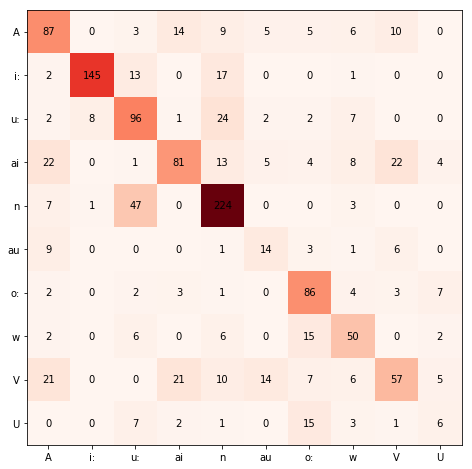

In [8]:
#-----------------------------------function to Generate a Confusion Matrix----------------------------------
def buildConfusionMatrix(result, expected):
    predictionMatrixIndexing = {}
    confusionMatrix = [[0 for x in range(0, len(targetPhones))] for x in range(0, len(targetPhones))]
    targetPhonesList = list(targetPhones)
    for index in range(0, len(targetPhonesList)):
        predictionMatrixIndexing[targetPhonesList[index]] = index
    for i in range(0,len(result)):
        confusionMatrix[predictionMatrixIndexing[expected[i]]][predictionMatrixIndexing[result[i]]] += 1
    return [targetPhones,confusionMatrix]



#--------------------------------generate confusion matrix, and render heat map------------------------------
confusionMatrix = buildConfusionMatrix(allInputs, allOutputs)
plt.figure(figsize=(8, 8))
column_labels = list(confusionMatrix[0])
row_labels = list(confusionMatrix[0])
plt.xticks(range(len(row_labels)), row_labels, size='medium')
plt.yticks(range(len(row_labels)), row_labels, size='medium')


#annotations
for row in range(0, len(confusionMatrix[1])):
    for col in range(0, len(row_labels)):
        plt.text(col , row, confusionMatrix[1][row][col],  horizontalalignment='center', verticalalignment='center', size='medium')
plt.imshow(confusionMatrix[1], cmap='Reds', interpolation='nearest')
plt.show()  
